# Model Evaluation

In [37]:
seed = 2020

import warnings
warnings.filterwarnings("ignore")

import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import roc_curve,roc_auc_score, brier_score_loss, average_precision_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import plot_precision_recall_curve, precision_score, recall_score, f1_score
import shap

np.random.RandomState(seed=seed)
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams.update({'font.size': 11})

x_train = pd.read_csv('processed_data/x_train.csv')
x_train = x_train.drop(x_train.columns[0],axis=1)
y_train = pd.read_csv('processed_data/y_train.csv')
y_train = y_train.drop(y_train.columns[0],axis=1)
y_train = y_train.T.squeeze()

x_test = pd.read_csv('processed_data/x_test.csv')
x_test = x_test.drop(x_test.columns[0],axis=1)
y_test = pd.read_csv('processed_data/y_test.csv')
y_test = y_test.drop(y_test.columns[0],axis=1)
y_test = y_test.T.squeeze()
best_model = joblib.load(f'pickled_objects/LVTRES_best_model.pkl')

bootstrap_reps = 10000

In [38]:
def bootstrap_statistics(clf,x_test,y_test,bootstrap_reps):
    """
    Nonparametric bootstrap to obtain confidence intervals for model performance on the test set.
    
    Parameters
    ----------
    clf: sklearn.Estimator
        A fitted sklearn model
    x_test: array-like
        Array of test set predictors
    y_test: array-like
        Array of test set labels
    bootstrap_reps: int
        Number of bootstrap replicates
    
    Returns
    -------
    output_dict: dict
        A nested dictionary containing the bootstrap results for the following summary statistics: AUROC, AUPRC, Sensitivity, Specificity, PPV
        Also contains a nested list of indices for each bootstrap value 
    
    """
    bs_auprc = []
    bs_auc = []
    bs_brier = []
    bs_sensitivity = []
    bs_specificity = []
    bs_ppv = []
    index_list = []
    for i in range(bootstrap_reps):
        idx = np.random.choice(np.array(range(len(x_test))),size=len(x_test),replace=True)
        y_pred_proba = clf.predict_proba(x_test.iloc[idx])[::,1]
        ap_score = average_precision_score(y_test[idx], y_pred_proba)
        bs_auprc.append(ap_score)
        auc_score = roc_auc_score(y_test[idx], y_pred_proba)
        bs_auc.append(auc_score)
        tn, fp, fn, tp = confusion_matrix(y_test[idx], y_pred_proba >= 0.5).ravel()
        brier = brier_score_loss(y_test[idx],y_pred_proba)
        sensitivity = tp/(tp+fn) 
        specificity = tn/(tn+fp)
        ppv = tp/(tp+fp)
        bs_brier.append(brier)
        bs_sensitivity.append(sensitivity)
        bs_specificity.append(specificity)
        bs_ppv.append(ppv)
        index_list.append(idx.tolist())
    
    output_dict = {'auprc':bs_auprc,'auc':bs_auc,'brier':bs_brier,'sensitivity':bs_sensitivity,'specificity':bs_specificity,'ppv':bs_ppv,'indices':index_list}
    
    return output_dict
    
bootstrap_dict = bootstrap_statistics(best_model,x_test,y_test,bootstrap_reps=bootstrap_reps)

In [39]:
def get_closest_index(lst,value):
    """
    Function to get the closest index of a value in a list
    
    Parameters
    ----------
    lst: list
        A list where you want to find an index of a value
    value: float64
        A value of interest
        
    Returns
    -------
    index: int
        The index of the closest value to the input value in lst
    """
    try:
        closest_value = min(lst, key=lambda x:abs(x-value))
    except Exception as e:
        raise e
    index = lst.index(closest_value)
    return index

def mean_95ci(lst,index_list):
    """
    A function to obtain the mean and 95% confidence intervals from a list of boostrapped results
    
    Parameters
    ----------
    lst: list
        A list of bootstrap results
    index_list: lst
        A list of indices for the test set data used during bootstrap resampling
    
    Returns
    -------
    mean: float64
        Bootstrap mean for the statistic of interest
    lowerbound: float64
        Bootstrap 2.5% quantile for the statistic of interest
    upperbound: float64
        Bootstrap 97.% quantile for the statistic of interest
    mean_indices:
        Indices of the test set data used to obtain the bootstrap mean
    lower_indices:
        Indices of the test set data used to obtain the bootstrap 2.5% quantile
    upper_indices:
        Indices of the test set data used to obtain the bootstrap 97.5% quantile
    """
    
    array = np.array(lst)

    lowerbound = np.quantile(array,0.025)
    lower_indices = get_closest_index(lst,lowerbound)
    lowerbound = np.round(lowerbound,3)

    upperbound = np.quantile(array,0.975)
    upper_indices = get_closest_index(lst,upperbound)
    upperbound = np.round(upperbound,3)

    mean = np.mean(array)
    mean_indices = get_closest_index(lst,mean)
    mean = np.round(mean,3)

    mean_indices = index_list[mean_indices]
    lower_indices = index_list[lower_indices]
    upper_indices = index_list[upper_indices]
    
    return mean, lowerbound, upperbound, (mean_indices,lower_indices,upper_indices)

In [40]:
auprc_mean,auprc_lowerbound,auprc_upperbound,index_tpl = mean_95ci(bootstrap_dict['auprc'],bootstrap_dict['indices'])
auc_mean,auc_lowerbound,auc_upperbound,index_tpl = mean_95ci(bootstrap_dict['auc'],bootstrap_dict['indices'])
brier_mean,brier_lowerbound,brier_upperbound,index_tpl = mean_95ci(bootstrap_dict['brier'],bootstrap_dict['indices'])

In [41]:
print('Additional Metrics - at cutoff p = 0.5')
y_score = best_model.predict_proba(x_test)[:, 1]
tn, fp, fn, tp = confusion_matrix(y_test, y_score >= 0.5).ravel()
sensitivity = tp/(tp+fn) 
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)

_,sensitivity_lowerbound,sensitivity_upperbound,_ = mean_95ci(bootstrap_dict['sensitivity'],bootstrap_dict['indices'])
print(f'Sensitivity: {np.round(sensitivity,3)} (95% CI {sensitivity_lowerbound}-{sensitivity_upperbound})')
_,specificity_lowerbound,specificity_upperbound,_ = mean_95ci(bootstrap_dict['specificity'],bootstrap_dict['indices'])
print(f'Specificity: {np.round(specificity,3)} (95% CI {specificity_lowerbound}-{specificity_upperbound})')
_,ppv_lowerbound,ppv_upperbound,_ = mean_95ci(bootstrap_dict['ppv'],bootstrap_dict['indices'])
print(f'Positive Predictive Value: {np.round(ppv,3)} (95% CI {ppv_lowerbound}-{ppv_upperbound})')

Additional Metrics - at cutoff p = 0.5
Sensitivity: 0.872 (95% CI 0.758-0.972)
Specificity: 0.636 (95% CI 0.423-0.84)
Positive Predictive Value: 0.81 (95% CI 0.682-0.923)


# Plots

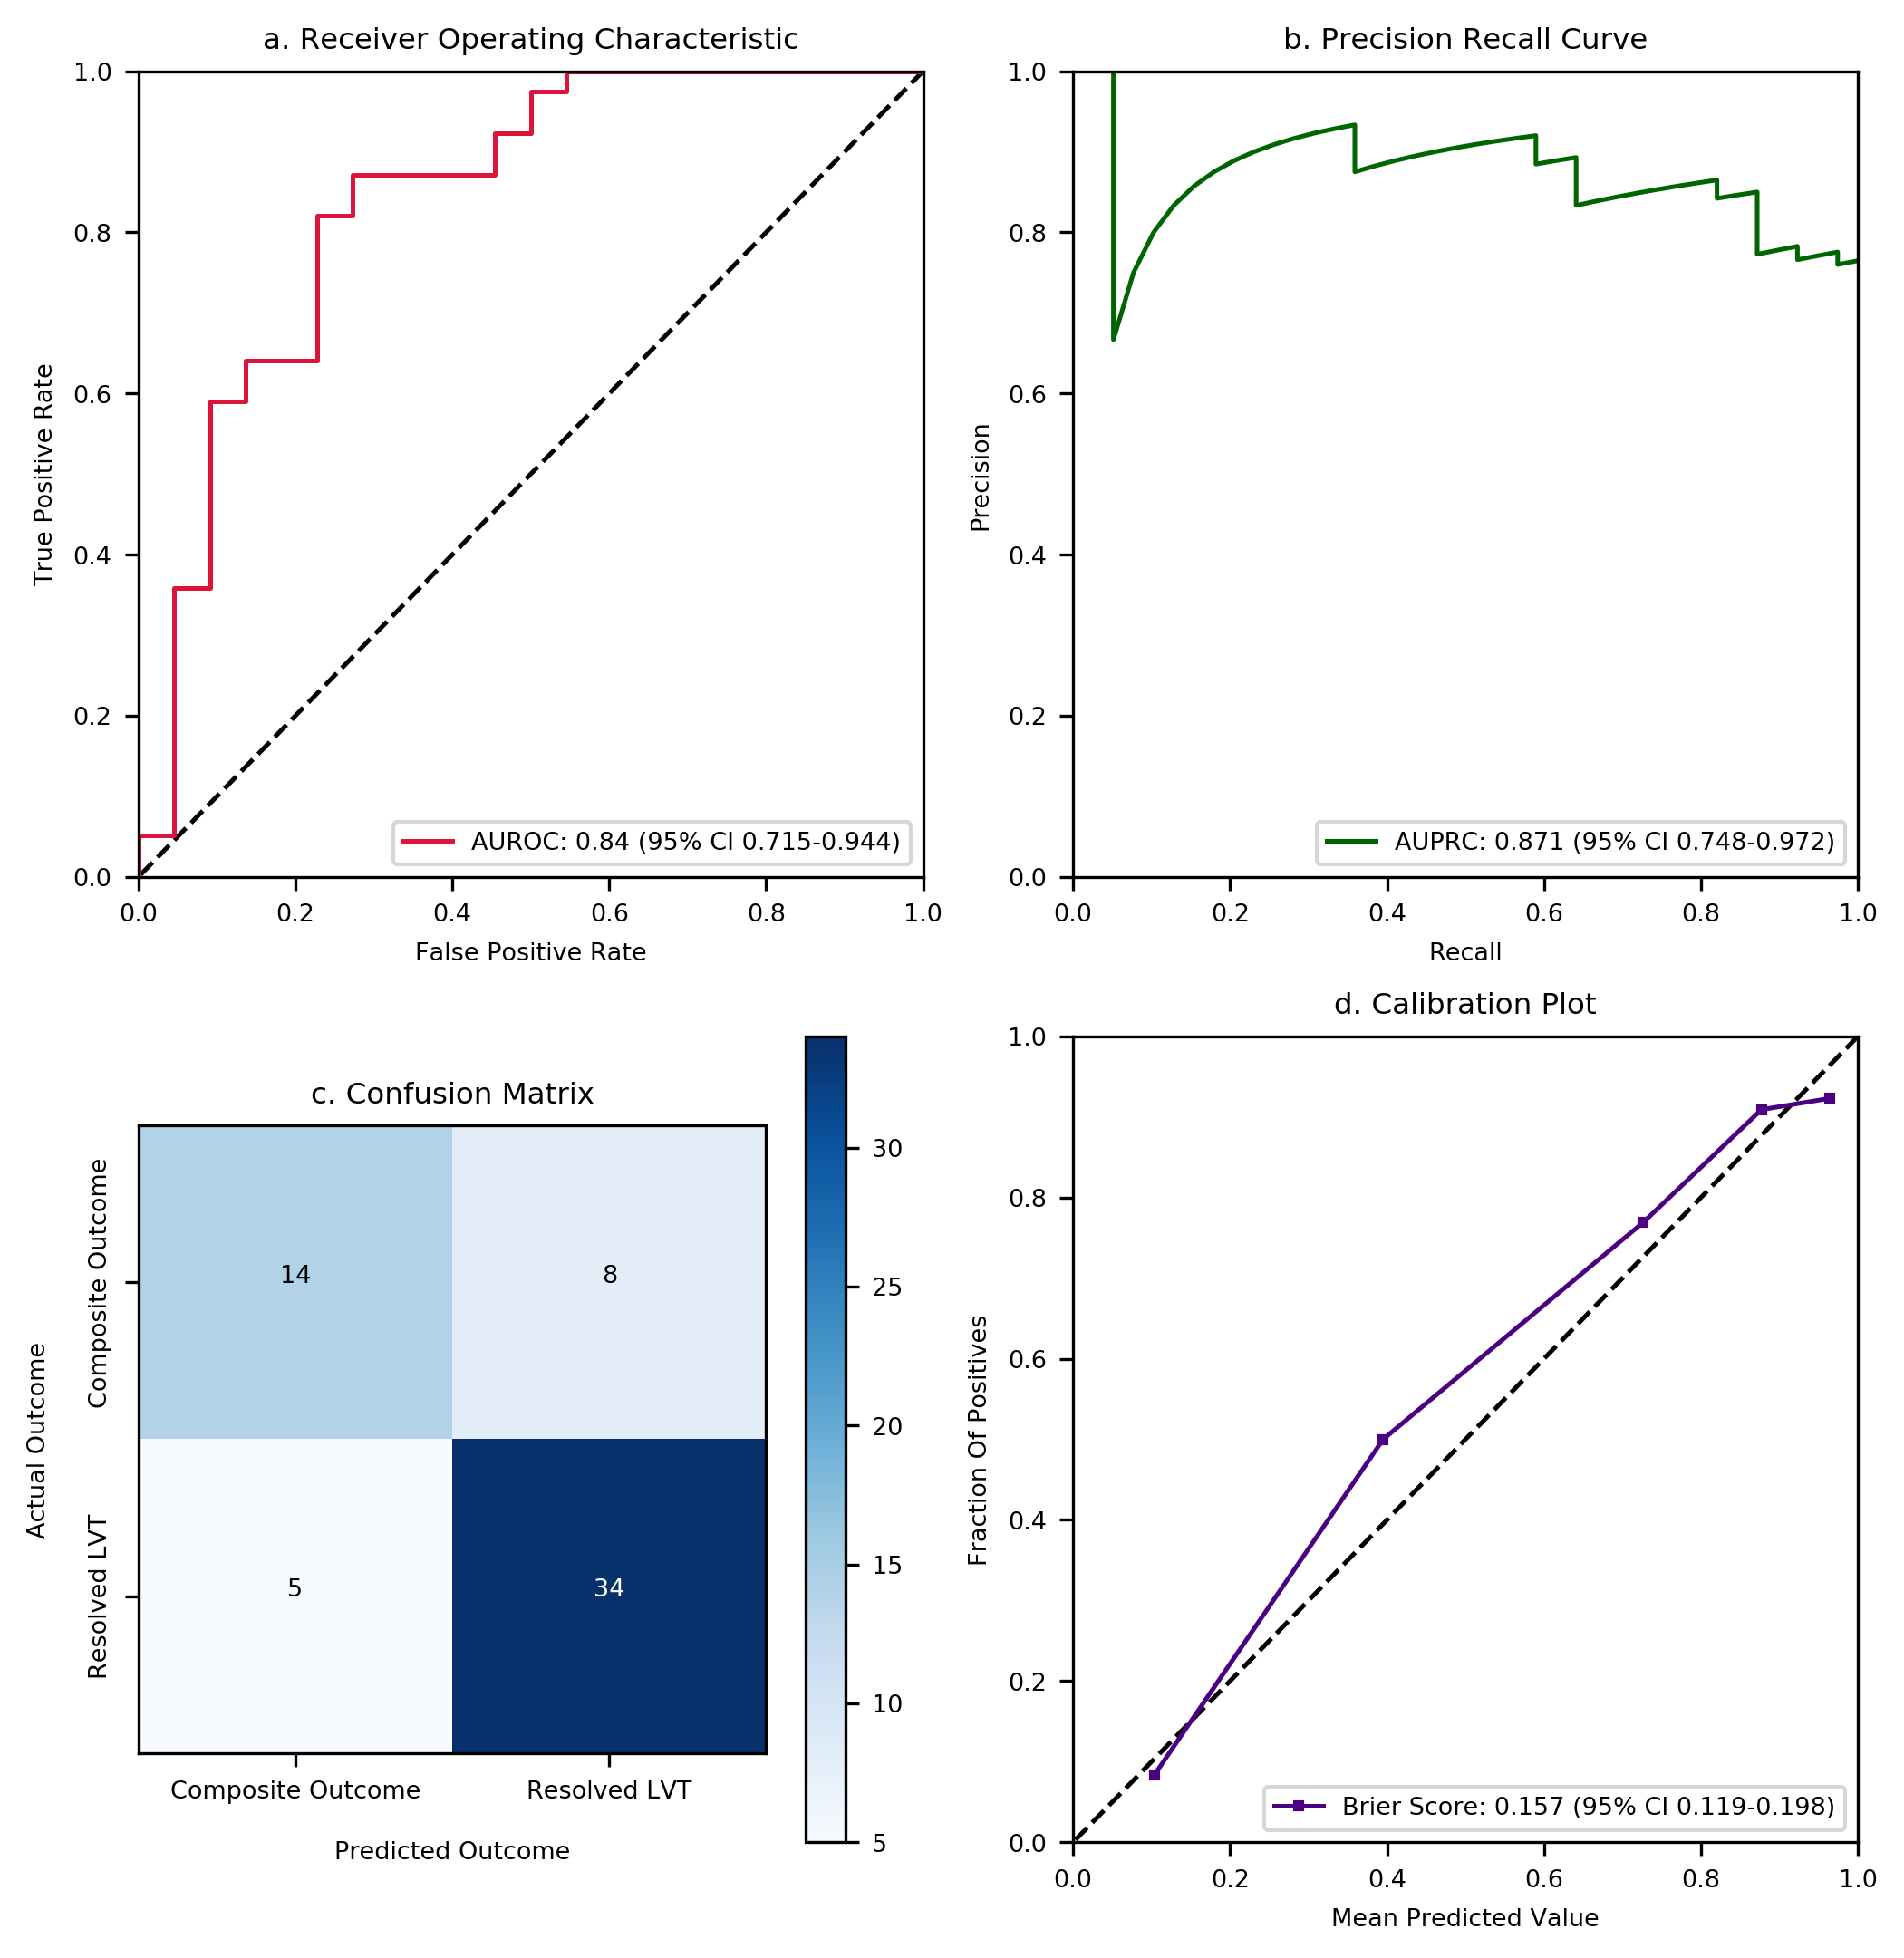

In [42]:
plt.figure(figsize=(7, 7.2))
mpl.rcParams.update({'font.size': 6.5})
lw = 1.2

prob_pos = best_model.predict_proba(x_test)[:,1]
test_fpr,test_tpr, _ = roc_curve(y_test,prob_pos)
test_auroc = roc_auc_score(y_test, prob_pos)
plt.subplot(2,2,1)
plt.title('a. Receiver Operating Characteristic')
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([1, 0], [1, 0],"k--",linewidth=lw)
label_string = f'AUROC: {np.round(test_auroc,2)} (95% CI {auc_lowerbound}-{auc_upperbound})'
plt.plot(test_fpr,test_tpr,label=label_string,color='crimson',linewidth=lw)
plt.legend(loc='lower right')

plt.subplot(2,2,2)
plt.title('b. Precision Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.ylim(0.,1.)
plt.xlim(0.,1.)
test_ap_score = average_precision_score(y_test, prob_pos)
label_string = f'AUPRC: {np.round(test_ap_score,3)} (95% CI {auprc_lowerbound}-{auprc_upperbound})'
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, prob_pos)
plt.plot(recall, precision,label=label_string, color='darkgreen',linewidth=lw)
plt.legend(loc='lower right')

# Plot confusion matrix
plt.subplot(2,2,3)
cm = confusion_matrix(y_test, prob_pos >= 0.5,normalize=None)
cm = np.round(cm,2)
classes = ['Composite Outcome','Resolved LVT']
title='c. Confusion Matrix'
cmap=plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes,rotation=90,va='center')
thresh = cm.max() / 2.
import itertools
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel('Predicted Outcome',labelpad=10)
plt.ylabel('Actual Outcome',labelpad=10)

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=6,normalize=True,strategy='quantile')
title_calibration='d. Calibration Plot'
plt.subplot(2,2,4)
plt.title(title_calibration)
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.ylabel("Fraction Of Positives")
plt.xlabel("Mean Predicted Value")
plt.plot([1, 0], [1, 0],"k--",linewidth=lw)
fraction_of_positives, mean_predicted_value = calibration_curve(y_test,prob_pos,strategy='quantile',normalize=True,n_bins=5)
brier_score = brier_score_loss(y_test,prob_pos)
plt.plot(mean_predicted_value, fraction_of_positives, "rs-",markersize=2,label=f'Brier Score: {np.round(brier_score,3)} (95% CI {brier_lowerbound}-{brier_upperbound})',color='indigo',linewidth=lw)
plt.legend(loc="lower right")
plt.savefig('Figure 2.png',bbox_inches='tight')
plt.tight_layout()

Using 183 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


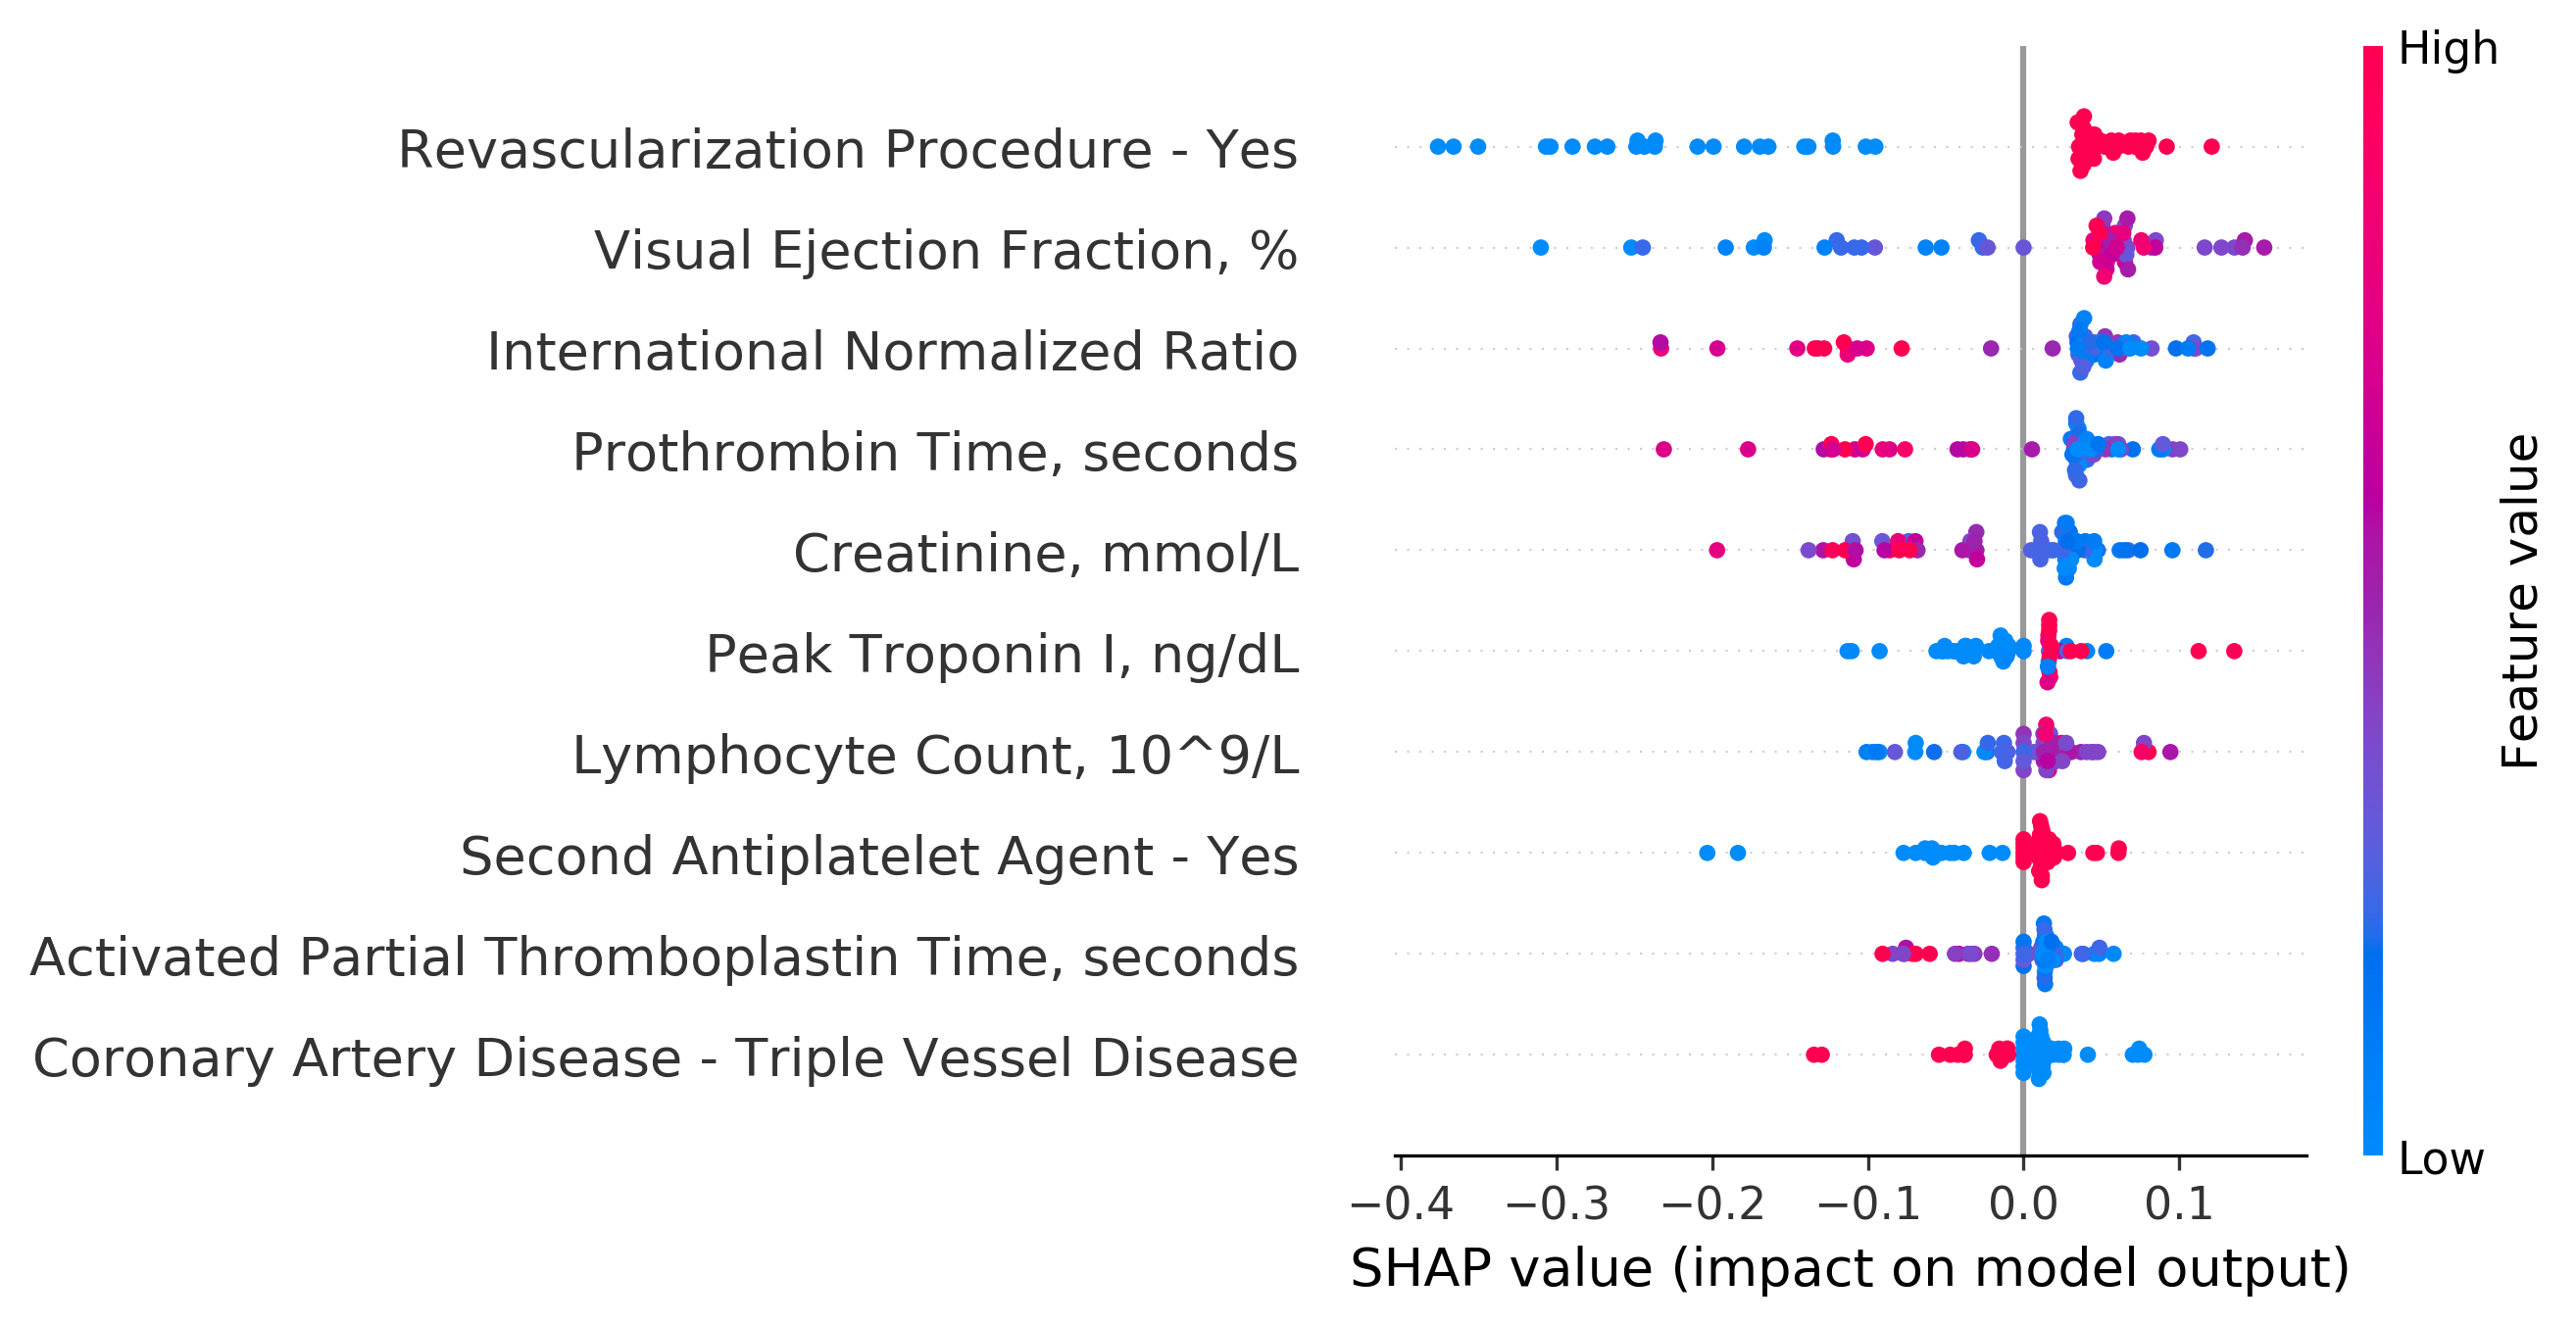

In [65]:
plt.ioff()
gbm_shap_values = shap.KernelExplainer(best_model.predict, x_train).shap_values(x_test)
x_test.columns = [name.replace('_',' - ')  for name in x_test.columns]
shap.summary_plot(gbm_shap_values, x_test,plot_size=(5,5),show=False,plot_type='dot',max_display=10)
plt.savefig("Variable Importance.png",bbox_inches = "tight")